In [1]:
from scipy.ndimage import imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
%matplotlib inline

Se hizo el experimento de escribir a mano sobre un papel una serie de digitos, con el fin de poder extraerlos y reconocerlos con nuestro clasificador. Se utilizaron varias herramientas como Numpy, Scipy, Scikit-Image y OpenCV para preprocesamiento y búsqueda de contornos.

En la figura ? se tiene la captura de la hoja de papel con los dígitos escritos con marcadores de diferente grosor, y distinto tipo de letra.

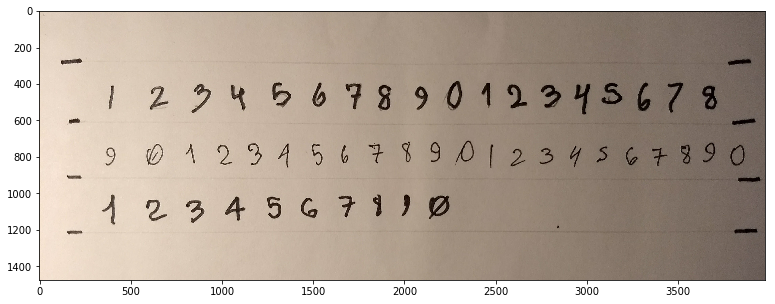

In [2]:
papel = imread('../doc/img/papel.jpg')
plt.figure(figsize=(13,13))
plt.imshow(papel)

In [3]:
def plot_img(img, **kwargs):
    plt.figure(figsize=(12,13))
    plt.xticks(range(0, img.shape[1], 200))
    plt.yticks(range(0, img.shape[0], 100))
    plt.imshow(img, cmap='gray', **kwargs)

## Preprocesamiento

Para poder alimentar la imagen al clasificador se debe primero preprocesar la imagen. Lo primero que se hizo fue pasar la imagen a escala de grises, tomar un umbral y binarizarla. El resultado de este proceso se puede ver en la figura ?.

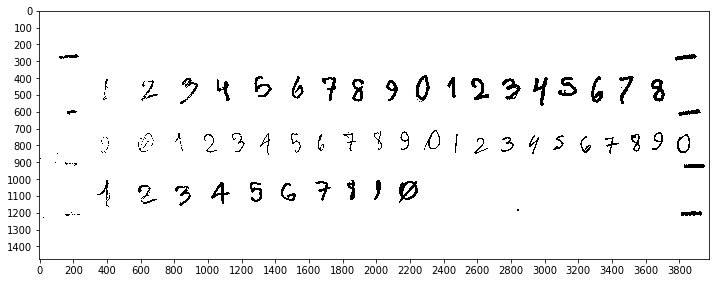

In [4]:
papel_umbral = imread('../doc/img/papel_umbral.jpg')
plot_img(papel_umbral)

In [5]:
from skimage import exposure

Dado las condiciones de luz de la imagen capturada, hay digitos que no se pueden ver bien. Para mejorar esto se ecualizó el histograma.

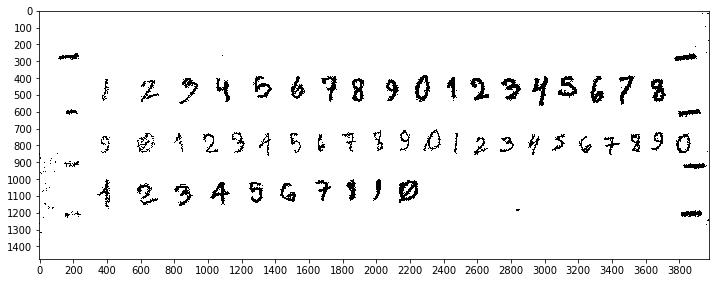

In [6]:
papel_eq = exposure.equalize_hist(papel_umbral)
plot_img(papel_eq)

In [7]:
from skimage.filters import median
from skimage.morphology import disk

Como último paso, se aplicó un filtro de mediana de $3\times3$ para mejorar el grosor de esos dígitos borrosos y eliminar otros tipos de ruido.

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


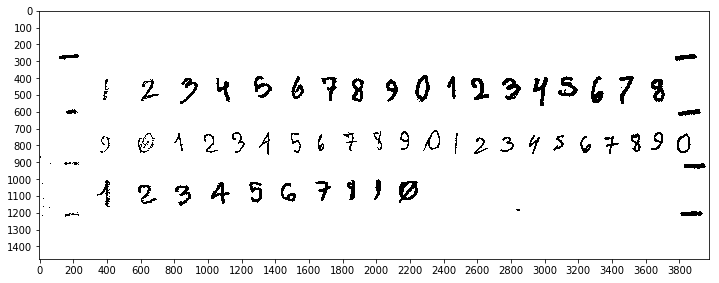

In [8]:
papel_med = median(papel_eq, disk(3))
plot_img(papel_med)

## Contornos

El siguiente paso fue hacer una búsqueda de contornos con OpenCV con la función `findContours`, que implementa el algoritmo propuesto por [Suzuki85] para encontrar contornos en una imagen binaria. Antes de eso, se tuvo que invertir la imagen para que el fondo tenga valor 0 y los digitos valores cercanos a 255.

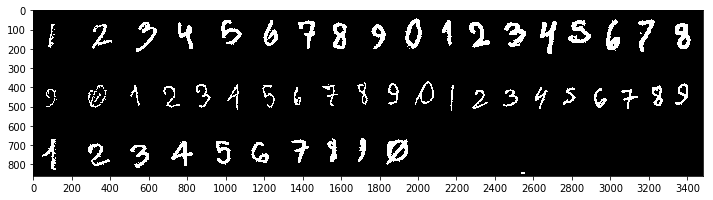

In [10]:
import cv2

cut = papel_med[340:960+240,300:3780]
neg = cv2.bitwise_not(cut)
plot_img(neg)

In [11]:
im2, contours, hierarchy = cv2.findContours(neg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [12]:
papel_cut = papel[340:960+240,300:3780]

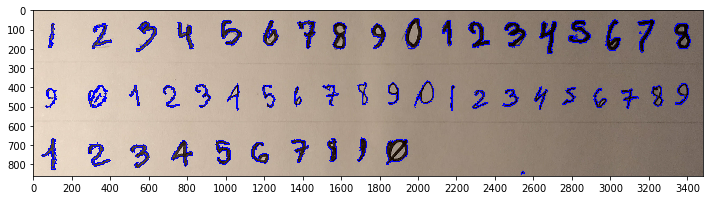

In [13]:
papel_contornos = cv2.drawContours(papel_cut.copy(), contours, -1, (0,0,255), 3)
plot_img(papel_contornos)

Teniendo los contornos, se calcularon los *bounding boxes* de los más grandes, obteniendo en la mayoría de los casos un recuadro de cada dígito.

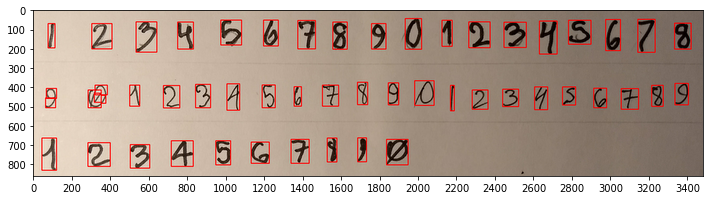

In [14]:
digitCnts = []; bboxes = []
papel_bb = papel_cut.copy()
 
# loop over the digit area candidates
for c in contours:
    # compute the bounding box of the contour and draw it
    x, y, w, h = cv2.boundingRect(c)
 
    # if the contour is sufficiently large, it must be a digit
    if w >= 20 and h >= 20:
        cv2.rectangle(papel_bb, (x,y), (x + w, y + h), (255, 0, 0), 3)
        bboxes.append({'left': x, 'right': x+w, 'top': y, 'bottom': y+h})
        
plot_img(papel_bb, interpolation='lanczos')

Se puede observar en la figura ? que hay algunos digitos que tienen más de un contorno, como el 0 de la segunda fila. Se podrían haber filtrarlos viendo si la distancia al más cercano es menor a cierto número (relacionado al ancho esperado de los digitos en la imagen), o buscando los rectángulos que intersecan y reemplazaros por uno que los contenga a todos, pero se decidió al final filtrarlos a mano dado que son pocos dígitos.

## Recortando los digitos, centrándolos y ajustando tamaño

A partir de los recuadros, se tomó un margen de 30 pixeles y se los recortó.

In [19]:
margin = 30
digits = [neg[b['top']-margin:b['bottom']+margin, b['left']-margin:b['right']+margin] for b in bboxes]

In [20]:
def plot_digits(digits):
    n_row = 6
    n_col = 10

    plt.figure(figsize=(14,9))
    for i, digit in enumerate(digits):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(digit, cmap='gray')
        plt.xticks(())
        plt.yticks(())

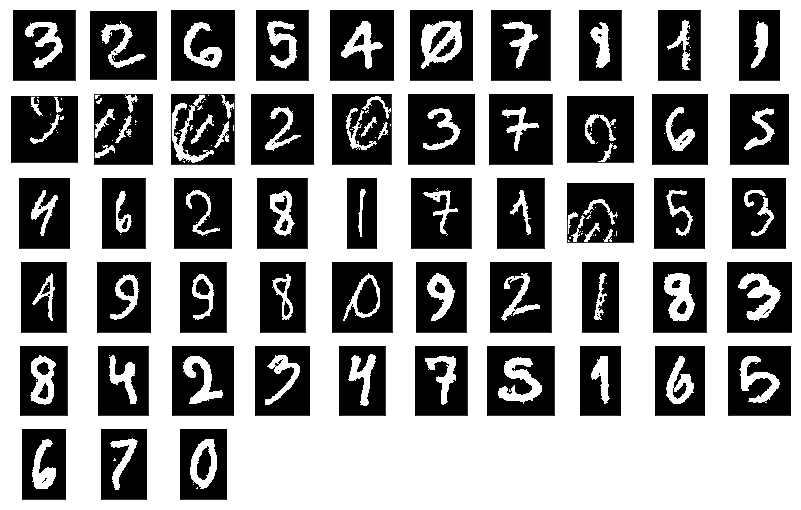

In [21]:
plot_digits(digits)

Finalmente, se ajustó el tamaño de cada imagen a $28 \times 28$, manteniendo el *aspect ratio* y reescalando con interpolación Lanczos, para evitar posibles distorsiones. En este paso también filtramos las imágenes repetidas o mal capturadas con el método de los contornos. En la figura ? se puede observar el resultado, ya listo para ser procesado por el clasificador.

In [158]:
from skimage.transform import resize
from skimage.util import pad

res_digits = []
for im in digits:
    #res_digits.append(resize(im, (28, 28)))
    #continue
    
    if max(im.shape) == im.shape[0]:
        size = 28, round((28 / im.shape[0]) * im.shape[1])
    else:
        size = round((28 / im.shape[1]) * im.shape[0]), 28
        
    new_im = im.copy()
    #new_im = cv2.blur(new_im,(3,3))
    #new_im = resize(im, size)  
    new_im = cv2.resize(new_im, (size[1], size[0]), interpolation=cv2.INTER_LANCZOS4);
    
    res = np.zeros((28, 28))
    h, w = new_im.shape
    left = 14 - (w//2); top = 14 - (h//2)
    res[top:top+h, left:left+w] = new_im
    res_digits.append(res)

48

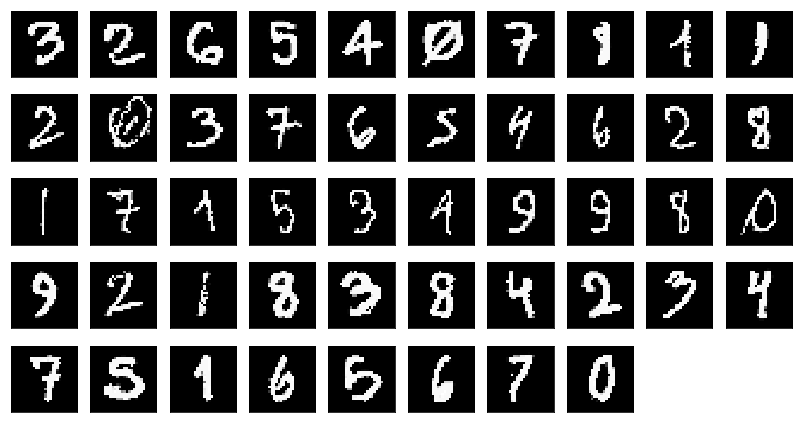

In [159]:
res_digits = [d for (i, d) in enumerate(res_digits) if i not in (10,11,12,17,27)]
plot_digits(res_digits)
len(res_digits)

Se etiquetaron las imágenes a mano, y se armaron los arrays para alimentar al clasificador.

In [160]:
X_test = np.array([d.ravel().astype(np.uint8) for d in res_digits])
y_test = np.array([
    3, 2, 6, 5, 4, 0, 7, 9, 1, 1,
    2, 0, 3, 7, 6, 5, 4, 6, 2, 8,
    1, 7, 1, 5, 3, 1, 9, 9, 8, 0,
    9, 2, 1, 8, 3, 8, 4, 2, 3, 4,
    7, 5, 1, 6, 5, 6, 7, 0])

In [161]:
X_test.shape, y_test.shape

((48, 784), (48,))

In [141]:
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('../py')
from exp import *

# Include path to binaries on PATH variable
bin_path = os.path.join(os.path.dirname('../'))
os.environ['PATH'] = "{}:{}".format(bin_path, os.environ['PATH'])

In [79]:
X, y = load_data('../data/train.csv')

In [80]:
clf = KnnClassifier(k=3, alpha=37, quiet=True)
clf.fit(X, y)

KnnClassifier(alpha=37, k=3, knn_path='knn', quiet=True, with_pca=True)

In [163]:
clf.score(X_test, y_test)

0.70833333333333337

In [164]:
y_pred = clf.predict(X_test)
y_pred

array([3, 2, 6, 3, 4, 6, 7, 1, 4, 1, 2, 6, 3, 7, 6, 5, 4, 6, 2, 8, 1, 8, 9,
       5, 3, 4, 5, 5, 8, 0, 9, 2, 1, 8, 3, 8, 4, 2, 7, 9, 7, 5, 1, 6, 6, 6,
       1, 0], dtype=uint8)

Podemos ver que el accuracy de correr el clasificador con todo el conjunto de entrenamiento sobre las imágenes procesadas es de 71%, más bajo que el obtenido en los experimentos anteriores. Corriéndolo con un porcentaje más alto de componentes principales ($\alpha=100$), se obtiene una mejora, con 73% de accuracy.

In [177]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          only_errors=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    if only_errors:
        for i in range(cm.shape[0]):
            cm[i,i] = 0
        print('Cleared diagonal entries')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if only_errors and i == j:
            plt.text(j, i, '-')
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valor real')
    plt.xlabel('Valor predicho')

Confusion matrix, without normalization
[[2 0 0 0 0 0 2 0 0 0]
 [0 4 0 0 2 0 0 0 0 1]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 1 0 0]
 [0 0 0 0 3 0 0 0 0 1]
 [0 0 0 1 0 3 1 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 1 0 0 0 0 0 3 1 0]
 [0 0 0 0 0 0 0 0 4 0]
 [0 1 0 0 0 2 0 0 0 1]]


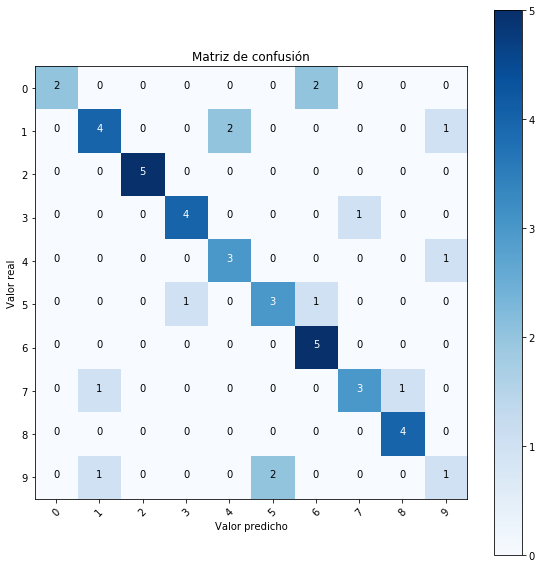

In [178]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=range(10), only_errors=False,
                      title='Matriz de confusión')

In [175]:
clf = KnnClassifier(k=3, alpha=100, quiet=True)
clf.fit(X, y)

KnnClassifier(alpha=100, k=3, knn_path='knn', quiet=True, with_pca=True)

In [176]:
clf.score(X_test, y_test)

0.72916666666666663